In [6]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import MinMaxScaler

# Segmentation / Change Point Detection

Split a continuous time series into segments where the underlying dta distribution is stable, mark where changes occur (mean, variance, correlation, or frequency)

1. Statistical Approaches

- Windowed statistic: Slide a window across the series and compute mean/variance. Big jumps suggest change point.

- CUMSUM test: For detecting shifts in the mean.

- Ruptures library: Package for change point detection. Supports dynamic programming, PELT, kernel-based detection.

2. Multivariate

- Accelerometer/gyro data has 3-6 channels. Ruptures can handle multidimensional series
- Try segmenting activities like sitting, walking, jogging

3. Compare methods (window statistics vs Ruptures)
- With ground truth data sets check accuracy
- With real data, check if detected segments match obvious activity transitions.


4. Use segmentation as preprocessing for clustering segments into states.

---


## Notes
### Signals
- Accelerometer (AccX, AccY, AccZ): measures linear acceleration (in m/s² or g’s) along three perpendicular axes.

- Gyroscope (GyroX, GyroY, GyroZ): measures angular velocity (in rad/s or deg/s) around those same axes.

- The exact orientation of X, Y, Z depends on how the device was worn,like phone in pocket or motion sensor on hip. X doesn’t necessarily mean left–right in the real world, it’s just one of the axes relative to the device.

### Sample rate (aka sampling frequency (fs)): 
- how many measurements are recorded per second. 
- So fs=100 Hz means: 100 samplers per second. Each sample is sample is spaced 1/100 of a second apart (1/100s = 0.10s = 100ms)
- If a trial has 10,000 rows, that means it lasted:
The duration is:
$$
\text{duration} = \frac{10{,}000 \ \text{samples}}{100 \ \text{samples/sec}} = 100 \ \text{seconds}
$$


---

## USC-HAD Dataset

- Mutlimodal wearable data: accelerometer and gyroscope readings from smartphone and wearable motion sensor.

- Rich activity transition: 12 daily activities. Ground truth for testing.

- Continuous signals: Each trial is sever minutes of sensor readings, so natural transitions.

- Public: https://sipi.usc.edu/had/ (.mat). Mi Zhang and Alexander A. Sawchuk, "USC-HAD: A Daily Activity Dataset for Ubiquitous Activity Recognition Using Wearable Sensors", ACM International Conference on Ubiquitous Computing (UbiComp) Workshop on Situation, Activity and Goal Awareness (SAGAware), Pittsburgh, Pennsylvania, USA, September 2012. 

- Notes: Doesn't stream long sequences as each activity is recorded separately in many trials. Concatenate trials to simulate transitions for long sequences with multiple activities mixed together

Plots with raw accelerometer signal along one axis (X) over time. A time-series trace of body motion in one direction.
- X-axis: the steps (sample index). Dataset is sampled at 100 Hz (so 100 samples = 1 second)
- Y-axis: acceleration values along the X axis.

What we see depends on activity:
- Walking: periodic wave (footsteps)
- Sitting: near flat signal
- Running: oscillations are larger and faster
- Standing up or transitioning: Sudden shift in baseline

### Exploratory Data Analysis (EDA)

In [7]:
# path to dataset
base_dir = "../data/USC-HAD"
subject = "Subject1"
trial_file = "a1t1.mat"  # activity 1 (walking), trial 1

# full path
file_path = os.path.join(base_dir, subject, trial_file)

# load .mat file
mat = scipy.io.loadmat(file_path)

# inspect keys
print(mat.keys())

# extract sensor data (6 channels: Acc XYZ, Gyro XYZ)
data = mat['sensor_readings']  # shape: (N, 6)

n = data.shape[0]
fs = 100              # sampling rate (Hz)
time = np.arange(n) / fs  # time in seconds


dict_keys(['__header__', '__version__', '__globals__', 'title', 'version', 'date', 'subject', 'age', 'height', 'weight', 'activity', 'activity_number', 'trial', 'sensor_location', 'sensor_orientation', 'sensor_readings'])


In [8]:
# 24 seconds, 6 channels
print(data.shape)

# check for missing data
print("NaNs?", np.isnan(data).any())
print("Infs?", np.isinf(data).any())

(2400, 6)
NaNs? False
Infs? False


In [9]:
print("Subject:", mat['subject'][0][0])
print("Age:", mat['age'][0][0])
print("Height (cm):", mat['height'][0][0])
print("Weight (kg):", mat['weight'][0][0])
print("Activity:", mat['activity'][0])
print("Activity Number:", mat['activity_number'][0][0])
print("Trial:", mat['trial'][0][0])
print("Sensor Location:", mat['sensor_location'][0])
print("Sensor Orientation:", mat['sensor_orientation'][0])


Subject: 1
Age: 2
Height (cm): 1
Weight (kg): 4
Activity: walking-forward
Activity Number: 1
Trial: 1
Sensor Location: front-right-hip
Sensor Orientation: x-gravity-y-walking-direction-z-vertical-to-walking-direction


Plots with raw accelerometer signal along one axis (X) over time. A time-series trace of body motion in one direction.
- X-axis: the steps (sample index). Dataset is sampled at 100 Hz (so 100 samples = 1 second)
- Y-axis: acceleration values along the X axis.

What we see depends on activity:
- Walking: periodic wave (footsteps)
- Sitting: near flat signal
- Running: oscillations are larger and faster
- Standing up or transitioning: Sudden shift in baseline

Notes:
- AccX = gravity direction. Vertical axis. Up/down motion. AccX +1g is like standing still.
- AccY = walking direction. Forward/back motion.
- AccZ = perpendicular to walking direction. Horizontal sideways. Lateral side-to-side motion.
- When standing still, we might see AccX ≈ +1 g, AccY ≈ 0, AccZ ≈ 0.
- When walking forward, AccY will show oscillations (steps), AccX will vary a bit (up-down bounce), and AccZ may pick up sway.
- Gyro channels match the same orientation but for angular velocity. Units degrees per second(dps)
- When concatenate activities, the vertical axis is stable (gravity is always there), which makes it a good check.

In [10]:
# plot accelerometer X as a simple time series

# extract accelerometer channels
AccX = data[:, 0]   # vertical (gravity axis)
AccY = data[:, 1]   # walking direction
AccZ = data[:, 2]   # lateral (side-to-side)

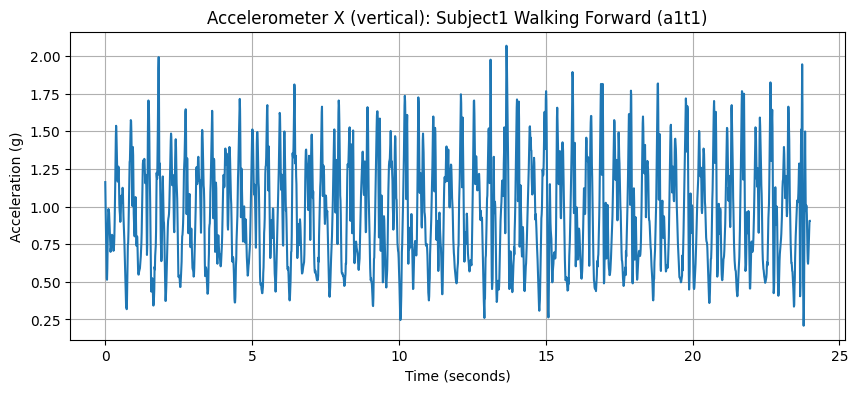

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(time, AccX)
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration (g)")
plt.title("Accelerometer X (vertical): Subject1 Walking Forward (a1t1)")
plt.grid(True)
plt.show()

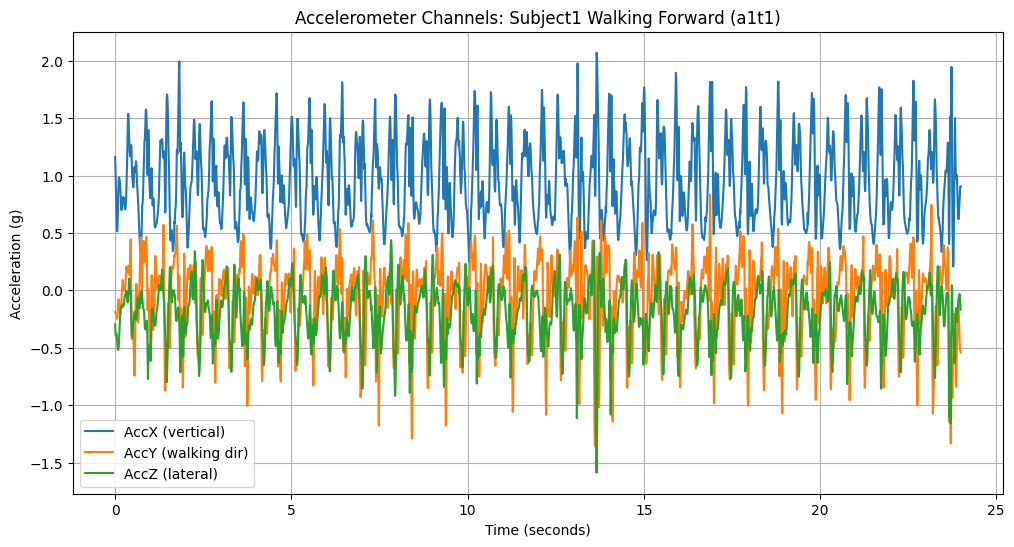

In [12]:

plt.figure(figsize=(12, 6))
plt.plot(time, AccX, label="AccX (vertical)")
plt.plot(time, AccY, label="AccY (walking dir)")
plt.plot(time, AccZ, label="AccZ (lateral)")

plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration (g)")
plt.title("Accelerometer Channels: Subject1 Walking Forward (a1t1)")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# extract gyroscope channels
GyroX = data[:, 3]   # rotation around vertical (gravity) axis
GyroY = data[:, 4]   # rotation around walking direction
GyroZ = data[:, 5]   # rotation around lateral axis

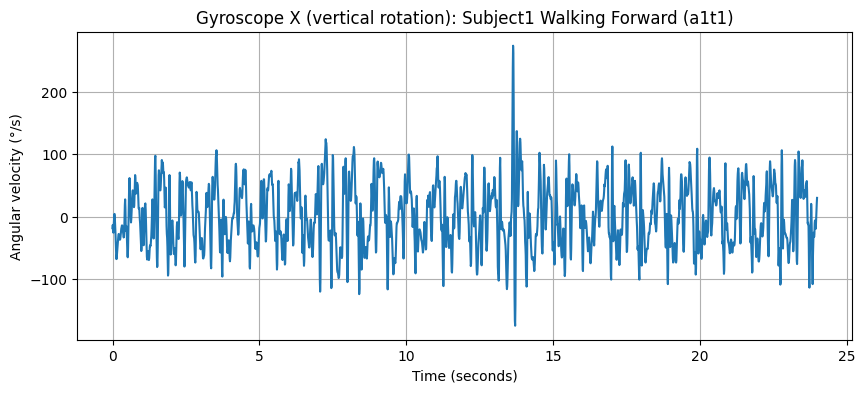

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(time, GyroX)
plt.xlabel("Time (seconds)")
plt.ylabel("Angular velocity (°/s)")
plt.title("Gyroscope X (vertical rotation): Subject1 Walking Forward (a1t1)")
plt.grid(True)
plt.show()

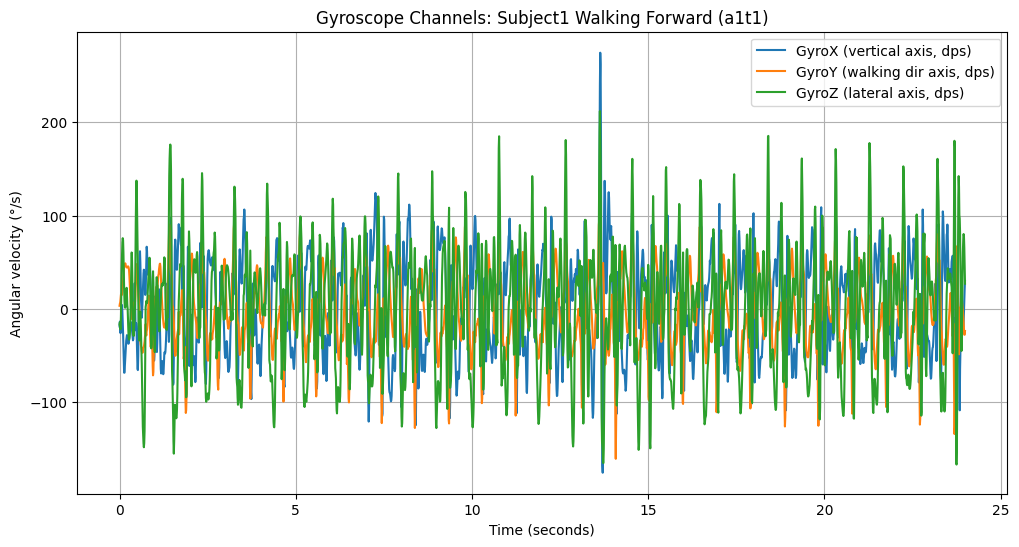

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(time, GyroX, label="GyroX (vertical axis, dps)")
plt.plot(time, GyroY, label="GyroY (walking dir axis, dps)")
plt.plot(time, GyroZ, label="GyroZ (lateral axis, dps)")

plt.xlabel("Time (seconds)")
plt.ylabel("Angular velocity (°/s)")
plt.title("Gyroscope Channels: Subject1 Walking Forward (a1t1)")
plt.legend()
plt.grid(True)
plt.show()

- GyroX (vertical axis): oscillates as hips rotate slightly left/right during steps.

- GyroY (walking dir): smaller, forward rotation of the hip isn’t as big.

- GyroZ (lateral): may show oscillations tied to up-down motion of walking.

The gyros complement the accelerometers: instead of how fast the body is moving in a direction, they capture how fast it’s rotating about an axis.

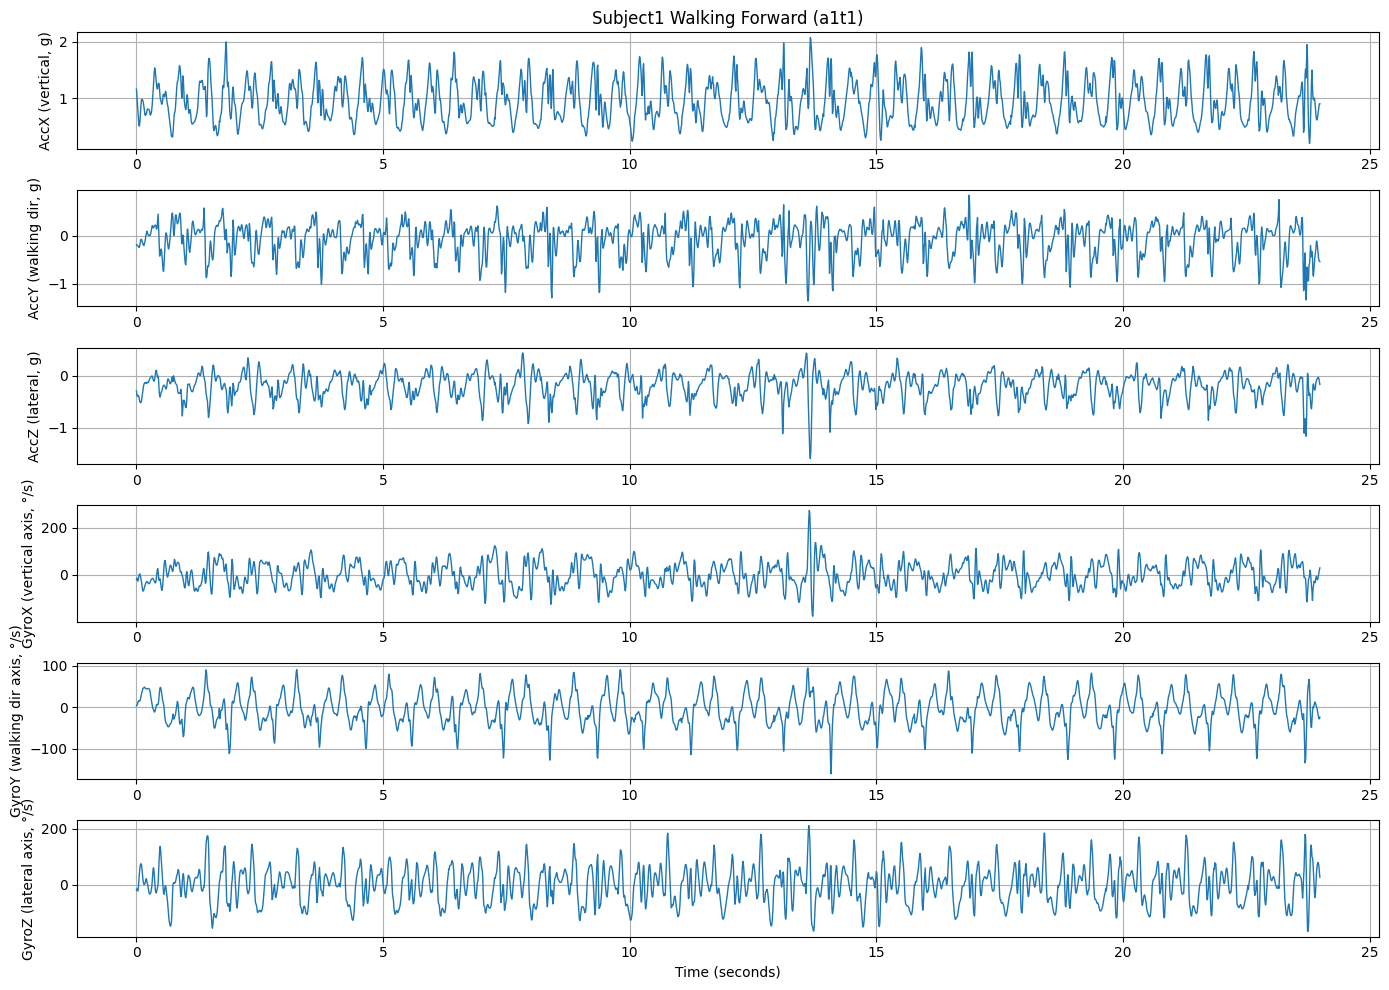

In [16]:

channel_names = [
    "AccX (vertical, g)", 
    "AccY (walking dir, g)", 
    "AccZ (lateral, g)", 
    "GyroX (vertical axis, °/s)", 
    "GyroY (walking dir axis, °/s)", 
    "GyroZ (lateral axis, °/s)"
]

plt.figure(figsize=(14, 10))

for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(time, data[:, i], lw=1)
    plt.ylabel(channel_names[i])
    if i == 0:
        plt.title("Subject1 Walking Forward (a1t1)")
    if i == 5:
        plt.xlabel("Time (seconds)")
    plt.grid(True)

plt.tight_layout()
plt.show()

Zoomed in on 5 seconds to analyze walking gait. Around 5 foot steps.

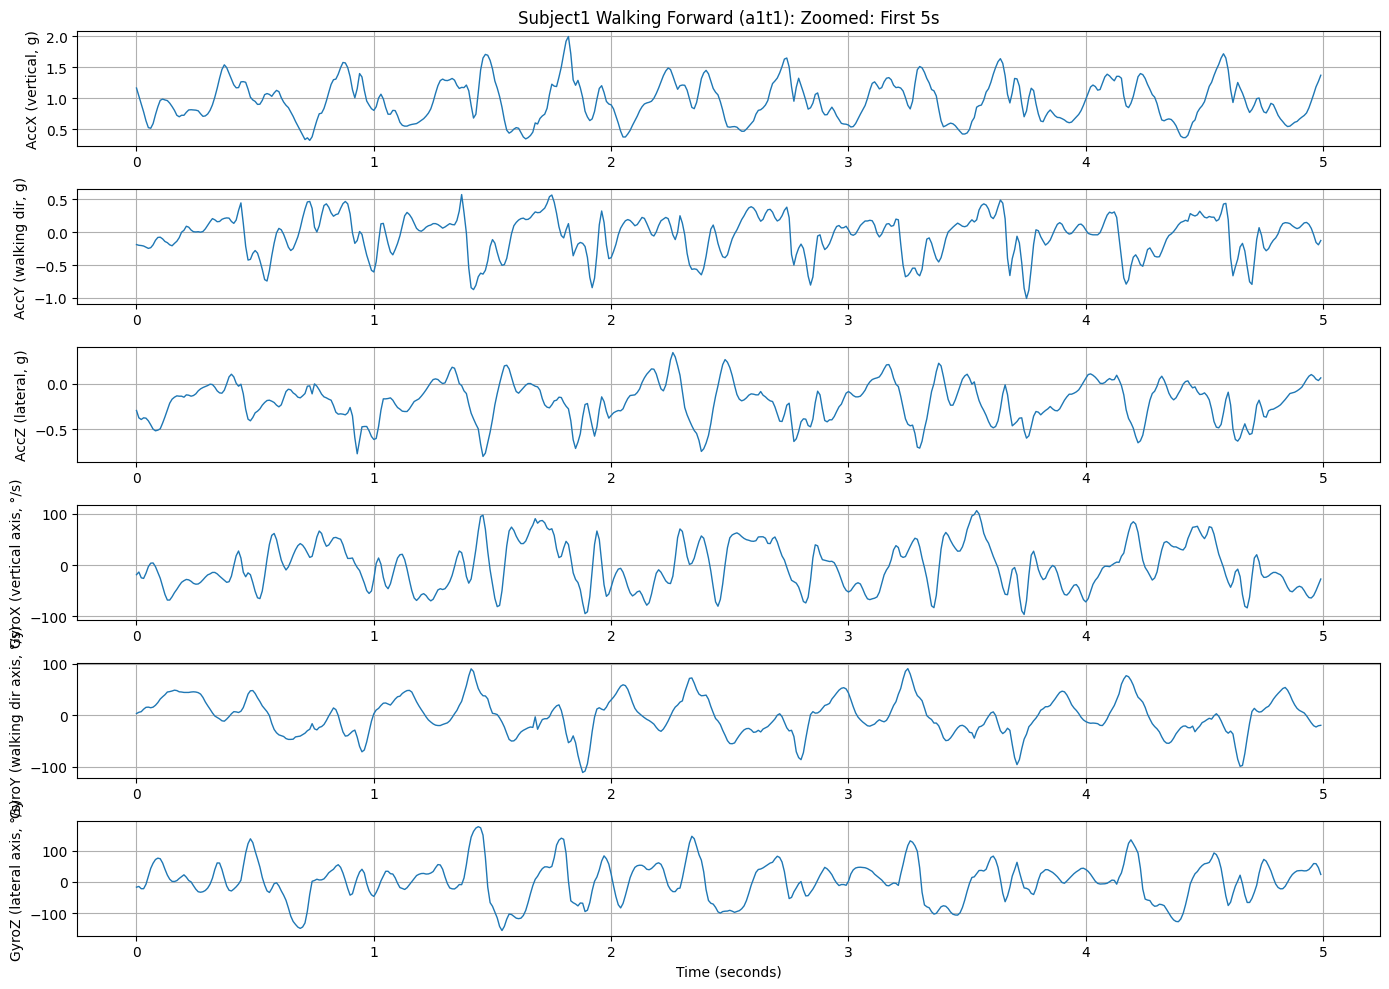

In [17]:
# zoom window (first 5 seconds = 500 samples)
start, end = 0, 5 * fs   # 0 to 500 samples
time_zoom = time[start:end]

plt.figure(figsize=(14, 10))

for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(time_zoom, data[start:end, i], lw=1)
    plt.ylabel(channel_names[i])
    if i == 0:
        plt.title("Subject1 Walking Forward (a1t1): Zoomed: First 5s")
    if i == 5:
        plt.xlabel("Time (seconds)")
    plt.grid(True)

plt.tight_layout()
plt.show()


---

### Segmentation

#### Concatenate Different Activities 

In [ ]:


base_dir = "../data/USC-HAD/Subject1"
lengths = []

for file in os.listdir(base_dir):
    if file.endswith(".mat"):
        mat = scipy.io.loadmat(os.path.join(base_dir, file))
        data = mat["sensor_readings"]
        lengths.append(data.shape[0])
        # n = data.shape[0]
        # duration = n / fs
        # print(f"{file}: {n} samples ({duration:.1f} sec)")

print("Sample lengths:", lengths)
print("Min length:", min(lengths))
print("Max length:", max(lengths))

Sample lengths: [5000, 4000, 4000, 5000, 1765, 1953, 1751, 4000, 5000, 5500, 4000, 1737, 4000, 4500, 1981, 1979, 2000, 1500, 1917, 2000, 1870, 2000, 1936, 1985, 2000, 1100, 6500, 3900, 4000, 6600, 1400, 2600, 2300, 7600, 1500, 4700, 3800, 2400, 3900, 3300, 1500, 2500, 2500, 3100, 1500, 1700, 1700, 7500, 3700, 6800, 1500, 7600, 3500, 1700, 1600, 2600, 3600, 5600, 3200, 3000]
Min length: 1100
Max length: 7600


Since samples are different lengths we may need to eventually pad or window for batching in DL later on.

We will start with a small run.

In [20]:
activity_files = {
    "walking-forward": "a1t1.mat",
    "running-forward": "a6t1.mat",
    "standing": "a9t1.mat",
    "sleeping": "a10t1.mat",
}

In [21]:
# for different permutations
activity_selection = ["walking-forward", "running-forward", "standing", "sleeping"]


In [22]:
# generate all permutations
permutations = list(itertools.permutations(activity_selection, len(activity_selection)))

sequences = {}  # store results

for i, sequence in enumerate(permutations, start=1):
    all_data = []
    boundaries = []
    offset = 0

    for act in sequence:
        file = activity_files[act]
        path = os.path.join(base_dir, file)
        mat = scipy.io.loadmat(path)
        data = mat["sensor_readings"]

        n = data.shape[0]
        all_data.append(data)

        offset += n
        boundaries.append(offset)

    concat_data = np.vstack(all_data)

    # save each sequence with unique name
    sequences[f"sequence{i}"] = {
        "order": sequence,
        "data": concat_data,
        "boundaries": boundaries
    }

# print summary
for name, seq in sequences.items():
    print(f"{name}: order={seq['order']}, shape={seq['data'].shape}")

sequence1: order=('walking-forward', 'running-forward', 'standing', 'sleeping'), shape=(10400, 6)
sequence2: order=('walking-forward', 'running-forward', 'sleeping', 'standing'), shape=(10400, 6)
sequence3: order=('walking-forward', 'standing', 'running-forward', 'sleeping'), shape=(10400, 6)
sequence4: order=('walking-forward', 'standing', 'sleeping', 'running-forward'), shape=(10400, 6)
sequence5: order=('walking-forward', 'sleeping', 'running-forward', 'standing'), shape=(10400, 6)
sequence6: order=('walking-forward', 'sleeping', 'standing', 'running-forward'), shape=(10400, 6)
sequence7: order=('running-forward', 'walking-forward', 'standing', 'sleeping'), shape=(10400, 6)
sequence8: order=('running-forward', 'walking-forward', 'sleeping', 'standing'), shape=(10400, 6)
sequence9: order=('running-forward', 'standing', 'walking-forward', 'sleeping'), shape=(10400, 6)
sequence10: order=('running-forward', 'standing', 'sleeping', 'walking-forward'), shape=(10400, 6)
sequence11: order=(

Concatenate sequence1

In [23]:

seq = sequences["sequence1"]

concat_data = seq["data"]          # concatenated sensor readings
boundaries = seq["boundaries"]     # list of end indices
order = seq["order"]               # activity order

print("Sequence1 order:", order)
print("Shape:", concat_data.shape)
print("Boundaries (samples):", boundaries)

Sequence1 order: ('walking-forward', 'running-forward', 'standing', 'sleeping')
Shape: (10400, 6)
Boundaries (samples): [2400, 3900, 5900, 10400]


#### Segment one channel

Plot AccY: Walking Direction

In [24]:
time = np.arange(concat_data.shape[0]) / fs
signal = concat_data[:, 1]  # AccY



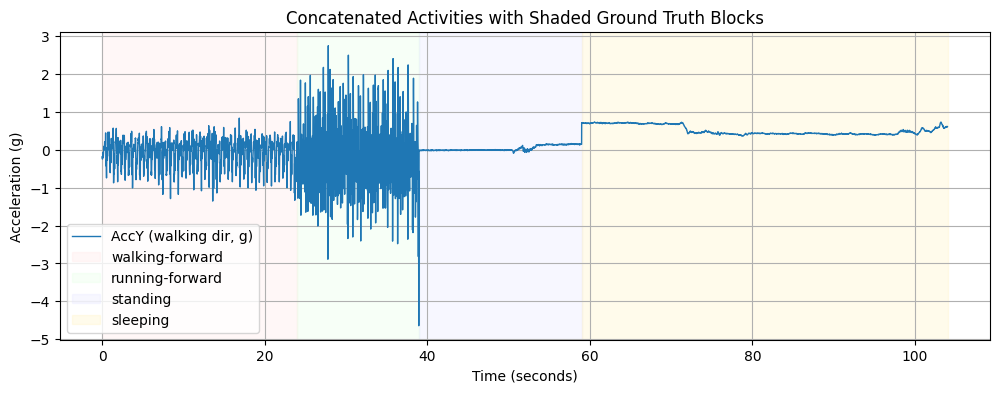

In [25]:
plt.figure(figsize=(12, 4))
plt.plot(time, signal, label="AccY (walking dir, g)", lw=1)

# shade each activity region
colors = ["#ffe0e0", "#e0ffe0", "#e0e0ff", "#fff0b3"]  # cycle colors
start = 0
for i, (b, act) in enumerate(zip(boundaries, order)):
    plt.axvspan(start/fs, b/fs, alpha=0.25, color=colors[i % len(colors)], label=act)
    start = b

plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration (g)")
plt.title("Concatenated Activities with Shaded Ground Truth Blocks")
plt.legend()
plt.grid(True)
plt.show()

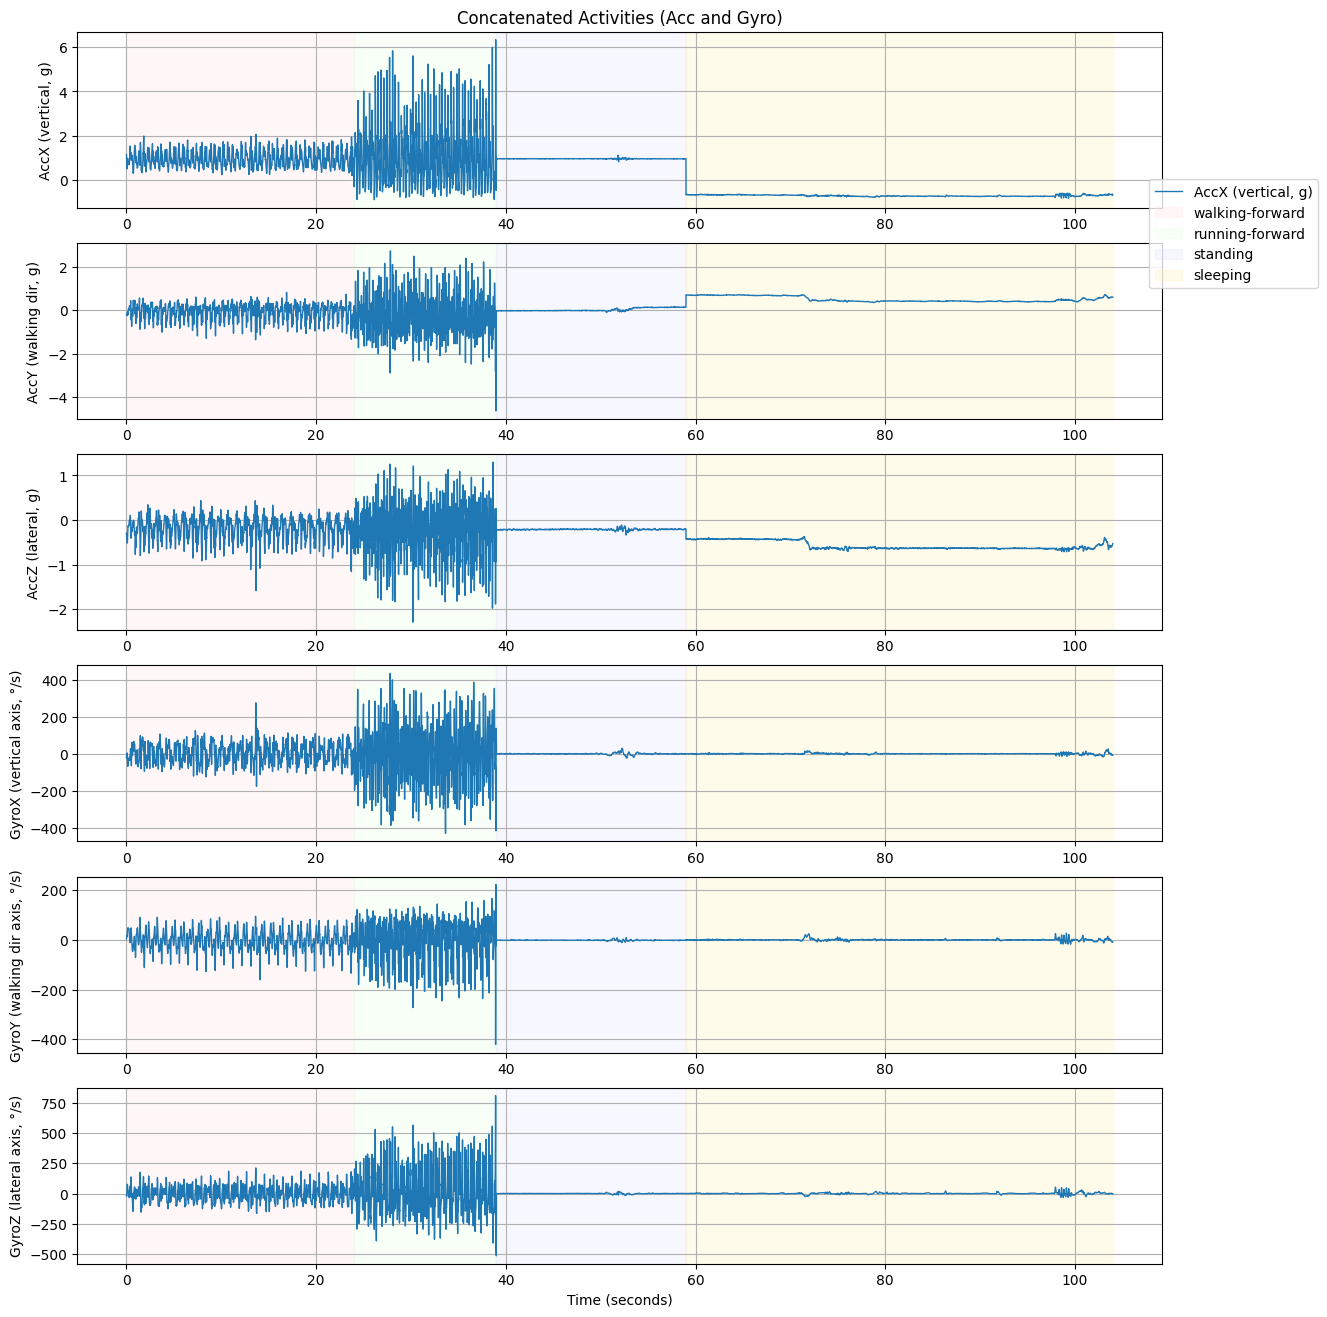

In [26]:
plt.figure(figsize=(14, 16))
colors = ["#ffe0e0", "#e0ffe0", "#e0e0ff", "#fff0b3"]

handles_labels = None

for i in range(6):
    ax = plt.subplot(6, 1, i+1)
    ax.plot(time, concat_data[:, i], lw=1, label=channel_names[i])
    
    # shade activity spans
    start = 0
    for j, (b, act) in enumerate(zip(boundaries, order)):
        span = ax.axvspan(start/fs, b/fs, alpha=0.25, color=colors[j % len(colors)], label=act if i == 0 else "")
        start = b
    
    ax.set_ylabel(channel_names[i])
    ax.grid(True)
    
    if i == 0:
        ax.set_title("Concatenated Activities (Acc and Gyro)")
    if i == 5:
        ax.set_xlabel("Time (seconds)")
    
    # capture handles/labels from the first subplot
    if i == 0:
        handles_labels = ax.get_legend_handles_labels()

# legend outside all subplots
if handles_labels:
    handles, labels = handles_labels
    plt.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 6.2))

# plt.tight_layout()
plt.show()


##### Statistical Methods

1. Sliding Window with Mean and Variance

In [27]:

window = 200                 # 2 seconds (200 samples at 100 Hz)

# Compute rolling variance
rolling_var = np.array([
    np.var(signal[i:i+window]) if i+window <= len(signal) else np.nan
    for i in range(len(signal))
])

rolling_mean = np.array([
    np.mean(signal[i:i+window]) if i+window <= len(signal) else np.nan
    for i in range(len(signal))
])

lag = 50  # ~0.5s lag
rolling_corr = np.array([
    np.corrcoef(signal[i:i+window], signal[i+lag:i+window+lag])[0,1]
    if i+window+lag <= len(signal) else np.nan
    for i in range(len(signal))
])



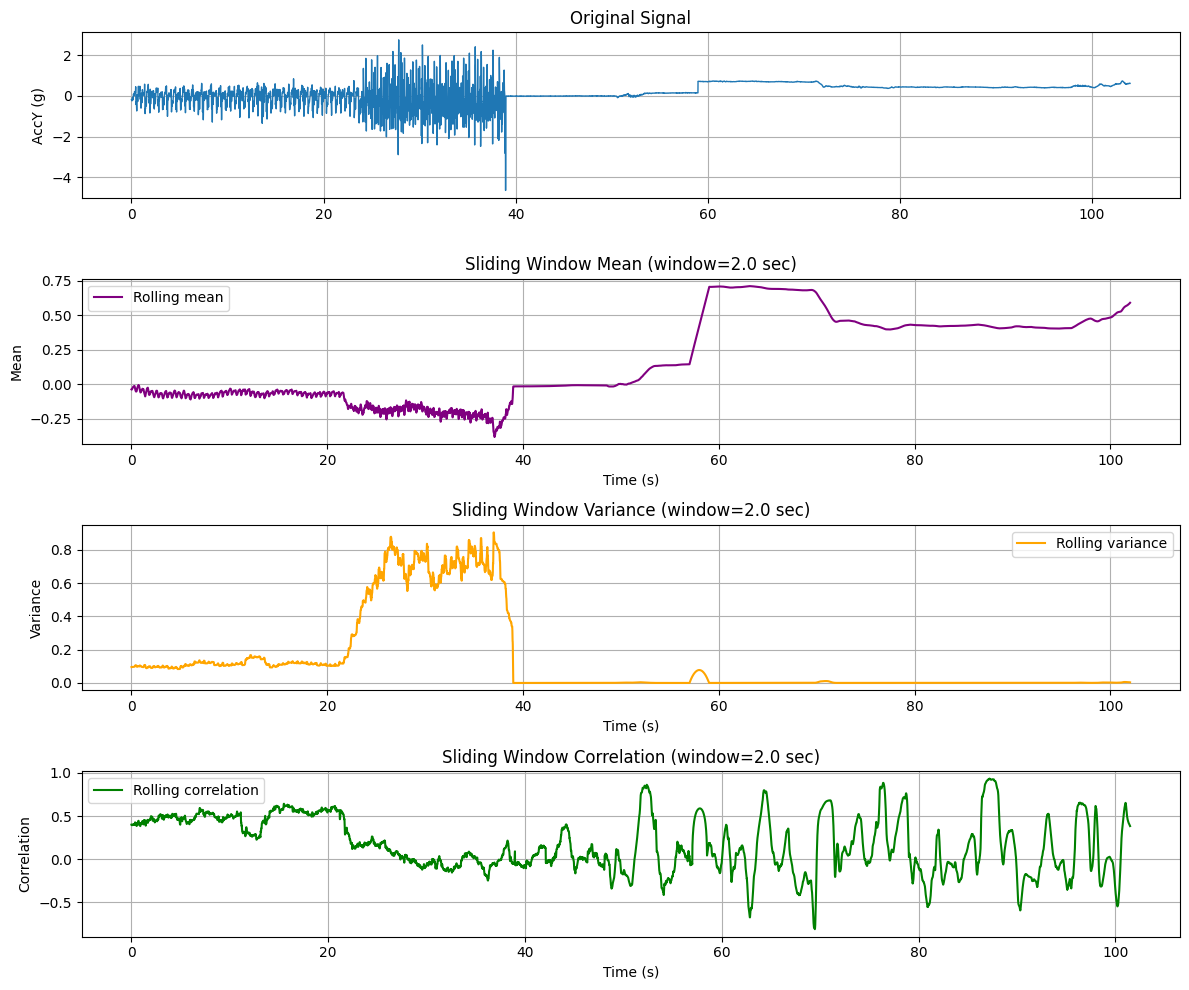

In [28]:
time = np.arange(len(signal)) / fs

plt.figure(figsize=(12, 10))

# original signal
plt.subplot(4, 1, 1)
plt.plot(time, signal, lw=1)
plt.ylabel("AccY (g)")
plt.title("Original Signal")
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(time, rolling_mean, color="purple", label="Rolling mean")
plt.ylabel("Mean")
plt.xlabel("Time (s)")
plt.title(f"Sliding Window Mean (window={window/fs:.1f} sec)")
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(time, rolling_var, color="orange", label="Rolling variance")
plt.ylabel("Variance")
plt.xlabel("Time (s)")
plt.title(f"Sliding Window Variance (window={window/fs:.1f} sec)")
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(time, rolling_corr, color="green", label="Rolling correlation")
plt.ylabel("Correlation")
plt.xlabel("Time (s)")
plt.title(f"Sliding Window Correlation (window={window/fs:.1f} sec)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

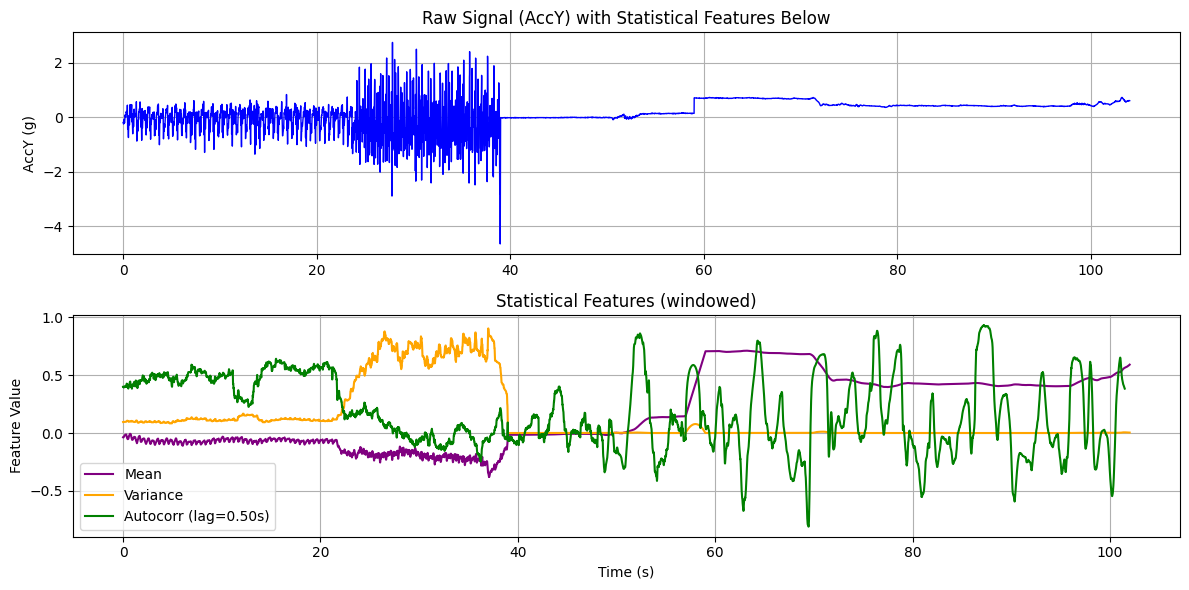

In [29]:
plt.figure(figsize=(12, 6))
# original
plt.subplot(2, 1, 1)
plt.plot(time, signal, lw=1, color="blue")
plt.ylabel("AccY (g)")
plt.title("Raw Signal (AccY) with Statistical Features Below")
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(time, rolling_mean, label="Mean", color="purple")
plt.plot(time, rolling_var, label="Variance", color="orange")
plt.plot(time, rolling_corr, label=f"Autocorr (lag={lag/fs:.2f}s)", color="green")
plt.xlabel("Time (s)")
plt.ylabel("Feature Value")
plt.title("Statistical Features (windowed)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

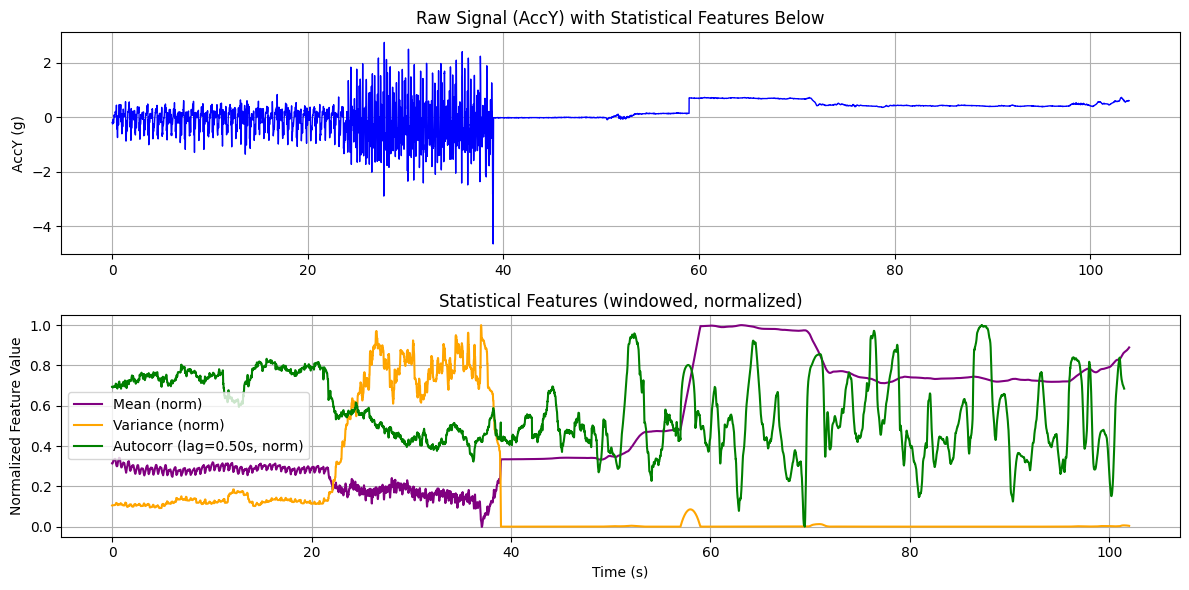

In [30]:

def normalize_feature(x):
    mask = ~np.isnan(x)
    scaler = MinMaxScaler()
    x_norm = np.full_like(x, np.nan, dtype=float)
    x_norm[mask] = scaler.fit_transform(x[mask].reshape(-1,1)).flatten()
    return x_norm

rolling_mean_norm = normalize_feature(rolling_mean)
rolling_var_norm = normalize_feature(rolling_var)
rolling_corr_norm = normalize_feature(rolling_corr)

plt.figure(figsize=(12, 6))


plt.subplot(2, 1, 1)
plt.plot(time, signal, lw=1, color="blue")
plt.ylabel("AccY (g)")
plt.title("Raw Signal (AccY) with Statistical Features Below")
plt.grid(True)

# normalized features
plt.subplot(2, 1, 2)
plt.plot(time, rolling_mean_norm, label="Mean (norm)", color="purple")
plt.plot(time, rolling_var_norm, label="Variance (norm)", color="orange")
plt.plot(time, rolling_corr_norm, label=f"Autocorr (lag={lag/fs:.2f}s, norm)", color="green")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Feature Value")
plt.title("Statistical Features (windowed, normalized)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()